In [1]:
# import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import re
import string
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [3]:
# read in dataset
news = pd.read_csv(train_url)

In [4]:
news.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


In [5]:
fake = len(news["fake"].unique())

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wangp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


news["title"] = news["title"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))
news["text"] = news["text"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "title" : news[["title"]], 
            "text" : news[["text"]]
        }, 
     
        {
            "fake" : news[["fake"]]
        }
    )
)

In [9]:
def make_dataset(df):

  # remove stopwords
  news["title"] = news["title"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))
  news["text"] = news["text"].apply(lambda x: ' '.join([i for i in x.split() if i not in (stopwords)]))

  # create dataset 
  dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            "title" : news[["title"]], 
            "text" : news[["text"]]
        }, 
     
        {
            "fake" : news[["fake"]]
        }
    )
  )
  
  # batch dataset
  dataset.batch(100)

  return dataset
  

In [10]:
news_data = make_dataset(news)

In [11]:
# split train/validation into 80/20
training_size = int(0.80 * len(news_data))
validation_size = int(0.20 * len(news_data))

train_set = news_data.take(training_size).batch(20)
validation_set = news_data.skip(training_size).take(validation_size).batch(20)

In [12]:
# calculate base rate of model 
iterator = train_set.unbatch().map(lambda x, news_data: news_data["fake"]).as_numpy_iterator()

number = 0
for num in iterator:
  if num == 1:
    number += 1

print(number / training_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.521911019544518


In [13]:
# create inputs for models 

# title is one dimension string type
title = keras.Input(
    shape = (1,), 
    name = "title",
    dtype = "string"
)

# text is 1D string type
text = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

In [14]:
vocab_limit = 2000

# remove all punctuations + lowercase all letters
def standardization(data):
    lower = tf.strings.lower(data)
    remove_punctuation = tf.strings.regex_replace(lower, '[%s]' % re.escape(string.punctuation),'')

    return remove_punctuation 

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = vocab_limit, # only consider this many words
    output_mode = 'int',
    output_sequence_length = 500) 

vectorize_layer.adapt(train_set.map(lambda x, y: x["title"]))
vectorize_layer.adapt(train_set.map(lambda x, y: x["text"]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [15]:
# functional API layers for 'title'
title_layer = vectorize_layer(title)
title_layer = layers.Embedding(vocab_limit, 3, name = "embedding")(title_layer)
title_layer = layers.Dropout(0.2)(title_layer)
title_layer = layers.GlobalAveragePooling1D()(title_layer)
title_layer = layers.Dropout(0.2)(title_layer)
title_layer = layers.Dense(32, activation = 'relu')(title_layer)

In [16]:
#functional API layers for 'text'
text_layer = vectorize_layer(text)
text_layer = layers.Embedding(vocab_limit, 3, name = "embedding")(text_layer)
text_layer = layers.Dropout(0.2)(text_layer)
text_layer = layers.GlobalAveragePooling1D()(text_layer)
text_layer = layers.Dropout(0.2)(text_layer)
text_layer = layers.Dense(32, activation = 'relu')(text_layer)

In [17]:
# 1st model (TITLE only)
output = layers.Dense(fake, name = "fake")(title_layer)


In [18]:
# 1st model (title only)
model1 = keras.Model(
    inputs = [title,],
    outputs = output
)


In [19]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
title (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 3)            6000      
_________________________________________________________________
dropout (Dropout)            (None, 500, 3)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 3)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)               

In [20]:
model1.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [21]:
# fit train set into 1st keras model
history = model1.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

C:\Users\wangp\anaconda3\envs\PIC16B\lib\site-packages\tensorflow\python\keras\engine\functional.py:540: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


In [22]:
# plot training vs validation history for model
def training_history(History):
  plt.plot(history.history["accuracy"], label = "training")
  plt.plot(history.history["val_accuracy"], label = "validation")
  plt.gca().set(title = "Training vs Validation Accuracy", xlabel = "Epoch", ylabel = "Accuracy")
  plt.legend()

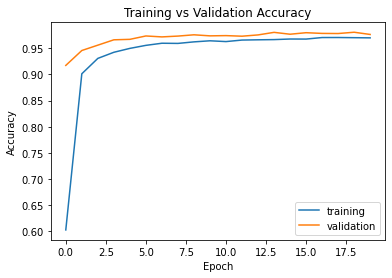

In [23]:
# MODEL 1 
training_history(history)

In [24]:
# 2nd model (TEXT only)

output = layers.Dense(fake, name = "fake")(text_layer)

model2 = keras.Model(
    inputs = [text,],
    outputs = output
)

model2.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)


In [25]:
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 3)            6000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 3)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 3)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [26]:
history = model2.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

C:\Users\wangp\anaconda3\envs\PIC16B\lib\site-packages\tensorflow\python\keras\engine\functional.py:540: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


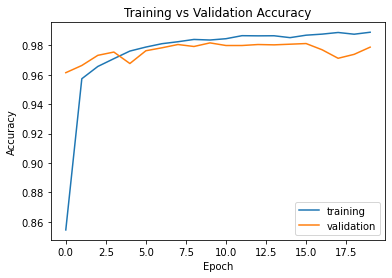

In [27]:
# MODEL 2
training_history(history)

In [28]:
# MODEL 3 (TITLE + TEXT)

title_layer = vectorize_layer(title)
title_layer = layers.Dense(32, activation = 'relu')(title_layer)

In [29]:
# both inputs combined
combined = layers.concatenate([title_layer, text_layer], axis = 1)

In [30]:
combined = layers.Dense(32, activation='relu')(combined)
output = layers.Dense(fake, name = "fake")(combined)

In [31]:
# model 3 (TITLE + TEXT)

model3 = keras.Model(
    inputs = [title, text],
    outputs = output
)

model3.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
)

In [32]:
model3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 500)          0           text[0][0]                       
                                                                 title[0][0]                      
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 3)       6000        text_vectorization[1][

In [33]:
history = model3.fit(train_set, 
                    validation_data = validation_set,
                    epochs = 20, 
                    verbose = False)

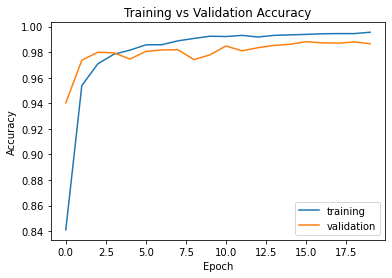

In [34]:
# MODEL 3
training_history(history)

In [35]:
# load in test set 
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

test_set = pd.read_csv(test_url)

In [36]:
# make test set into tensorflow dataset
test_news = make_dataset(test_set)

In [41]:
# evaluate test set using MODEL 3

model3.evaluate(test_news)

22449/22449 [==============================] - 35s 2ms/step - loss: 0.0206 - accuracy: 0.9963


[0.02060326561331749, 0.9962581992149353]

In [39]:
# embedding visualizations (MODEL 3)
weight = model3.get_layer('embedding').get_weights()[0] # get weights from the embedding layer
word_list = vectorize_layer.get_vocabulary()   # get all words found in dataset     


from sklearn.decomposition import PCA
pca = PCA(n_components = 2)  # 2D PCA
weights = pca.fit_transform(weight)


# create embedded dataframe with weights
embedding_df = pd.DataFrame({
    'word' : word_list, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

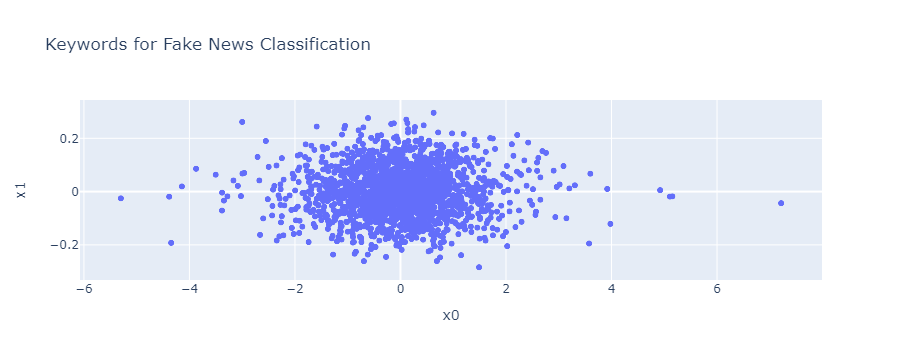

In [42]:
import plotly.express as px 

# plot embedded dataframe to visualize word distribution
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size_max = 2,
                 hover_name = "word",
                 title = "Keywords for Fake News Classification")

fig.show()